### create hourly Fraser turbidity time series where gaps 4 hrs or less are filled by linear interpolation

### create daily averages from hourly time series and fill larger gaps based on interpolation of daily averages

#### use Doug's scraped dataset since download is not currently available (at least past 2018)

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
import netCDF4 as nc
import string
import pandas as pd
from dateutil.parser import parse as dutparse
from salishsea_tools.evaltools import pac_to_utc, datetimeToDecDay
#from dataProcess import forceNumeric, forceInt, fmtVarName, data2Tbl, adFunONC
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
# set to last available data!
startdate=dt.date(2019,6,16)
enddate=dt.date(2019,10,11) # in this case end date is not included

Index(['# date', 'time', 'timezone', 'turbidity', 'turbidity units',
       'specific conductivity', 'specific conductivity units',
       'water temperature', 'water temperature units', 'pH', 'pH units',
       'dissolved oxygen', 'dissolved oxygen units', 'water depth',
       'water depth units', 'stream velocity', 'stream velocity units',
       'stream velocity direction', 'wind speed', 'wind speed units',
       'wind direction', 'wind bearing', 'air temperature',
       'air temperature units', 'relative humidity', 'relative humidity units',
       'atmospheric pressure', 'atmospheric pressure units', 'dtdate'],
      dtype='object')


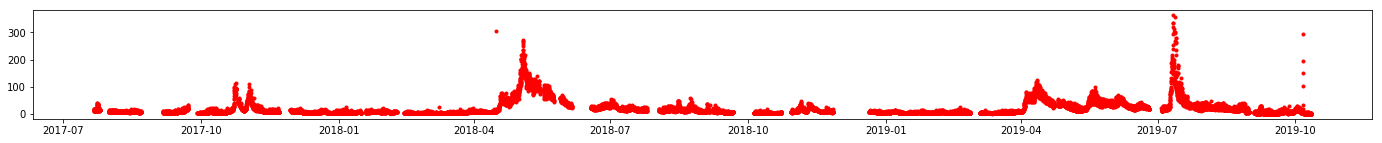

In [3]:
# load data; set negative turbidities to zero
tdf=pd.read_csv('/results/observations/ECCC/fraser_buoy.csv',header=0)
tdf['dtdate']=pd.to_datetime(tdf['# date']+' '+tdf['time'],format='%Y-%m-%d %H:%M:%S')
#    tdf['DD']=[_dateTimeToDecDay(jj) for jj in _pacToUTC(tdf['dtdate'].values)]
print(tdf.keys())
tdf.loc[tdf.turbidity<0,['turbidity']]=0
fig,ax=plt.subplots(1,1,figsize=(24,2))
ax.plot(tdf['dtdate'],tdf['turbidity'],'r.')

In [4]:
dates0=[dt.datetime.strptime(el[0]+'T'+el[1],'%Y-%m-%dT%H:%M:%S') for el in zip(tdf['# date'],tdf['time'])]
datesUTC=pac_to_utc(dates0)
datesUTC[0]

datetime.datetime(2017, 7, 21, 18, 10)

In [5]:
tdf['Turb_NTU']=tdf['turbidity']
tdf['DecDay']=datetimeToDecDay(datesUTC)

In [6]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + dt.timedelta(n)

In [7]:
dtdstart=dt.datetime(startdate.year,startdate.month,startdate.day)
dtdend=dt.datetime(enddate.year,enddate.month,enddate.day)
df=tdf.loc[(datesUTC>(dtdstart))&(datesUTC<(dtdend))&(tdf.turbidity<=200),['DecDay','Turb_NTU']].copy(deep=True)

In [8]:
df

,DecDay,Turb_NTU
14728,43630,18.23
14729,43630,17.43
14730,43630.1,16.96
14731,43630.1,16.64
14732,43630.2,17.73
14733,43630.2,18.15
14734,43630.3,18.69
14735,43630.3,20.08
14736,43630.3,16.73
14737,43630.4,17.94


In [9]:
df['daynum']=0*df['DecDay']
df['hr']=0*df['DecDay']

In [10]:
# create hash of daynum, hour pairs that are in df (where there is data)
#timeSet=set()
for index, row in df.iterrows():
    day=int(np.floor(row['DecDay']))
    hr=int(np.round((row['DecDay']-day)*24))
    df.loc[index,['daynum','hr']]=[day,hr]
    #timeSet=timeSet|set([(day,hr)])
#timeSet

In [11]:
# desired time series is from startdate to enddate
ndays=(enddate-startdate).days+1
ndays

118

In [12]:
dfout=pd.DataFrame(index=np.arange(0,ndays*24),
                   columns=('DayNum','Hour','Turb_NTU'))
dfdaily=pd.DataFrame(index=np.arange(0,ndays),columns=('DayNum','Turb_NTU'))

In [13]:
for ind,row in dfout.iterrows():
    dfout.iloc[ind]['DayNum','Hour']=[np.floor(ind/24.0)+(startdate-dt.date(1900,1,1)).days,ind%24]
    
for ind,row in dfdaily.iterrows():
    dfdaily.iloc[ind]['DayNum']=ind+(startdate-dt.date(1900,1,1)).days

In [14]:
df.loc[df.duplicated(subset=('daynum','hr'),keep=False)]

,DecDay,Turb_NTU,daynum,hr
14788,43632.5,21.00,43632,12
14789,43632.5,21.00,43632,12
14954,43639.4,19.37,43639,10
14955,43639.4,19.37,43639,10
14956,43639.4,19.37,43639,10
14957,43639.4,19.37,43639,10
14958,43639.4,19.37,43639,10
14959,43639.4,19.37,43639,10
14960,43639.4,19.37,43639,10
14961,43639.4,19.37,43639,10


In [15]:
# get rid ofduplicate rows
df.drop_duplicates(subset=('daynum','hr'),keep='first',inplace=True)
df.reset_index(inplace=True)

In [16]:
df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)]

,index,DecDay,Turb_NTU,daynum,hr
0,14728,43630,18.23,43630,0


In [17]:
df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)].iloc

In [18]:
df[(df.daynum==(enddate-dt.date(1900,1,1)-dt.timedelta(days=1)).days)&(df.hr==23)]

,index,DecDay,Turb_NTU,daynum,hr
2432,17533,43747,0.0,43746,23


/home/eolson/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


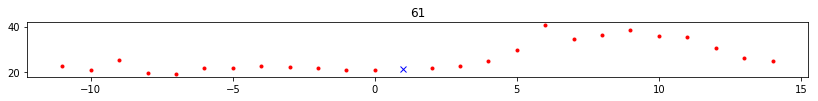

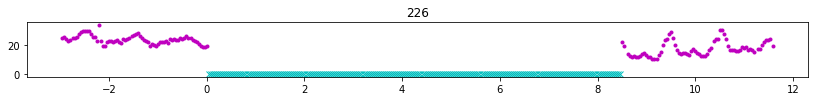

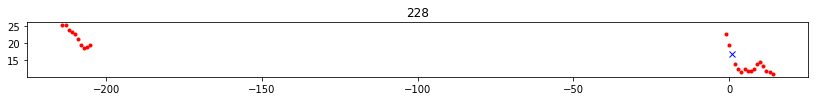

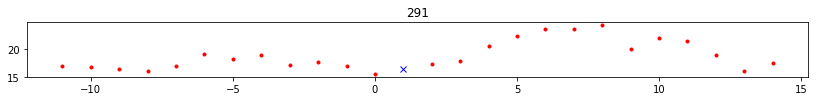

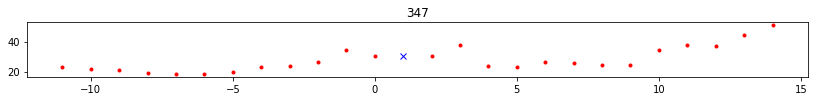

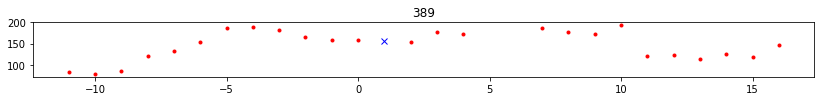

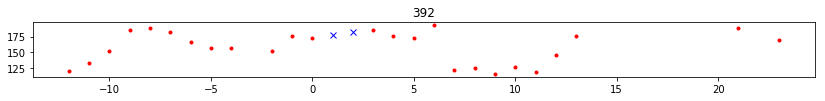

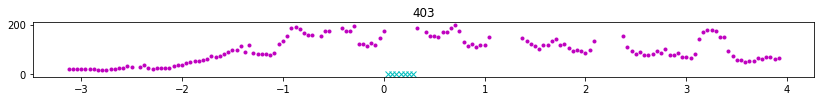

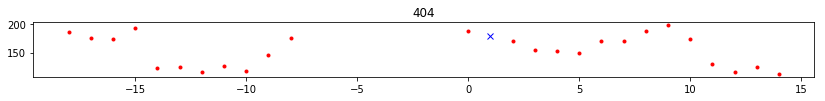

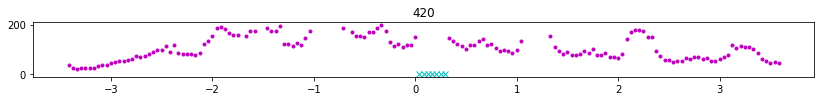

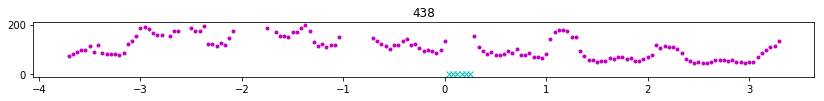

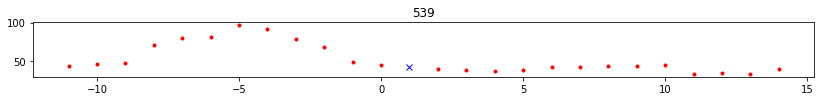

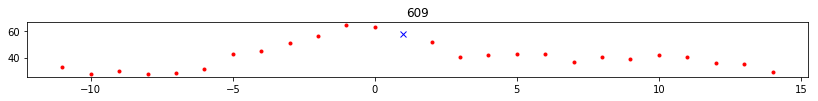

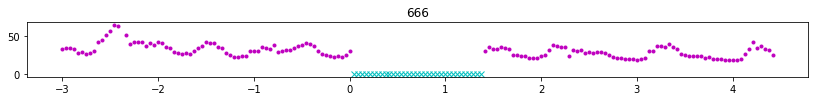

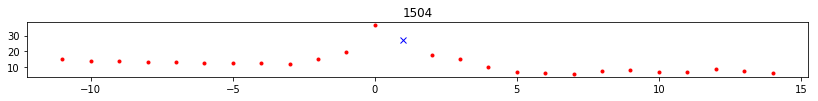

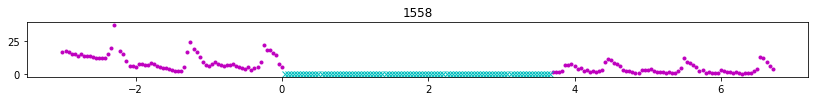

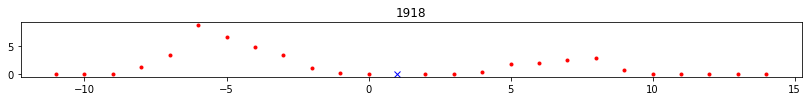

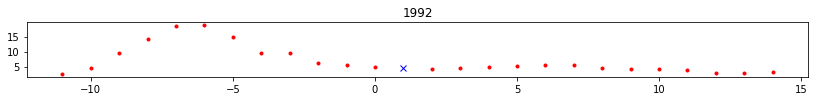

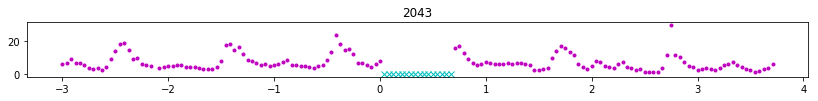

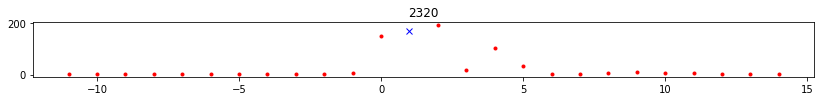

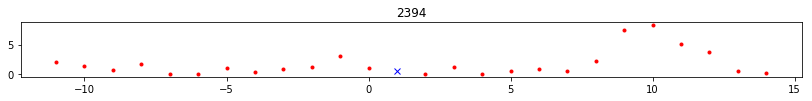

In [19]:
df0=df#[580:]
ddlast=df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)]['DecDay'].values[0]-1.0/24.0
iout=0
for ind, row in df0.iterrows():
    #print(ind)
    
    # linearly interpolate breaks of 4 hrs or less
    if (((row['DecDay']-ddlast)<5.5/24.0)&((row['DecDay']-ddlast)>1.5/24.0)): 
        tlast=df0.loc[ind-1]['Turb_NTU']
        tnext=row['Turb_NTU']
        ddnext=row['DecDay']
        nint=int(np.round((ddnext-ddlast)*24)-1)
        fig,ax=plt.subplots(1,1,figsize=(14,1))
        ax.plot((df0.loc[(ind-12):(ind+12)]['DecDay']-ddlast)*24,df0.loc[(ind-12):(ind+12)]['Turb_NTU'],'r.')
        ax.set_title(str(ind))
        for ii in range(1,nint+1):
            dd0=ddlast+ii/24.0
            tur0=tlast+(dd0-ddlast)/(ddnext-ddlast)*(tnext-tlast)
            ax.plot((dd0-ddlast)*24,tur0,'bx')
            if ((dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0)<.5/24.0):
                dfout.loc[iout]['Turb_NTU']=tur0
                iout+=1
            else:
                print('ERROR 2:')
                print(dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0,
                      dd0,dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0,.5/24.0)
                break
    elif ((row['DecDay']-ddlast)>5.5/24.0):# fill in larger holes with NaNs; interpolate between days later
        fig,ax=plt.subplots(1,1,figsize=(14,1))
        ax.plot(df0.loc[(ind-72):(ind+72)]['DecDay']-ddlast,df0.loc[(ind-72):(ind+72)]['Turb_NTU'],'m.')
        ax.set_title(str(ind))
        nint=int(np.round((row['DecDay']-ddlast)*24)-1)
        for ii in range(1,nint+1):
            dd0=ddlast+ii/24.0
            ax.plot((dd0-ddlast),0,'cx')
            if ((dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0)<.5/24.0):
                dfout.loc[iout]['Turb_NTU']=np.nan
                iout+=1
            else:
                print('ERROR 4:')
                break
    # always append current row's value
    if ((dfout.loc[iout]['DayNum']==row['daynum'])&(dfout.loc[iout]['Hour']==row['hr'])):
        dfout.loc[iout]['Turb_NTU']=row['Turb_NTU']
    else:
        print('ERROR 1:')
        print('iout=',iout,'ind=',ind)
        print(dfout.loc[iout]['DayNum'],row['daynum'],dfout.loc[iout]['Hour'],row['hr'])
        break
    iout+=1
    ddlast=row['DecDay']

In [20]:
df.iloc[55:65]

,index,DecDay,Turb_NTU,daynum,hr
55,14783,43632.3,21.90,43632,7
56,14784,43632.3,22.50,43632,8
57,14785,43632.4,22.39,43632,9
58,14786,43632.4,21.88,43632,10
59,14787,43632.5,20.81,43632,11
60,14788,43632.5,21.00,43632,12
61,14790,43632.6,21.84,43632,14
62,14791,43632.6,22.72,43632,15
63,14792,43632.7,24.79,43632,16
64,14793,43632.7,29.68,43632,17


In [21]:
dfout

,DayNum,Hour,Turb_NTU
0,43630,0,18.23
1,43630,1,17.43
2,43630,2,16.96
3,43630,3,16.64
4,43630,4,17.73
5,43630,5,18.15
6,43630,6,18.69
7,43630,7,20.08
8,43630,8,16.73
9,43630,9,17.94


In [22]:
for idd in range((startdate-dt.date(1900,1,1)).days,(enddate-dt.date(1900,1,1)).days):# intentionally don't fill in last one because of Nans
    tdata=dfout[(dfout.DayNum==idd)&(dfout.Turb_NTU>0)]['Turb_NTU'].values # exclude NaNs
    nn=len(tdata)
    if nn>19: #more  than 80% of day represented
        dfdaily.loc[dfdaily.DayNum==idd,'Turb_NTU']=np.mean(tdata)

In [23]:
dfdaily

,DayNum,Turb_NTU
0,43630,21.0067
1,43631,23.2433
2,43632,26.1179
3,43633,28.49
4,43634,29.2117
5,43635,27.6392
6,43636,25.9208
7,43637,24.6225
8,43638,23.2946
9,43639,NaN


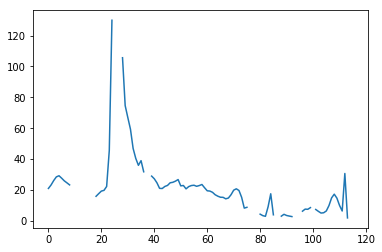

In [24]:
plt.plot(dfdaily['Turb_NTU'])

In [25]:
dds=dfdaily[dfdaily.Turb_NTU>0]['DayNum'].values
ts=dfdaily[dfdaily.Turb_NTU>0]['Turb_NTU'].values

In [26]:
dfnan=dfdaily[~(dfdaily.Turb_NTU>0)]
ddblanks=dfnan['DayNum'].values

In [27]:
dds1=[np.float(el) for el in dds]
ts1=[np.float(el) for el in ts]
ddblanks1=[np.float(el) for el in ddblanks]
tinterps=np.interp(ddblanks1,dds1,ts1)

In [28]:
oldDD=np.copy(dfdaily['DayNum'].values)
oldT=np.copy(dfdaily['Turb_NTU'].values)

In [29]:
for idd, newT in zip(ddblanks1,tinterps):
    dfdaily.loc[dfdaily.DayNum==idd,'Turb_NTU']=newT

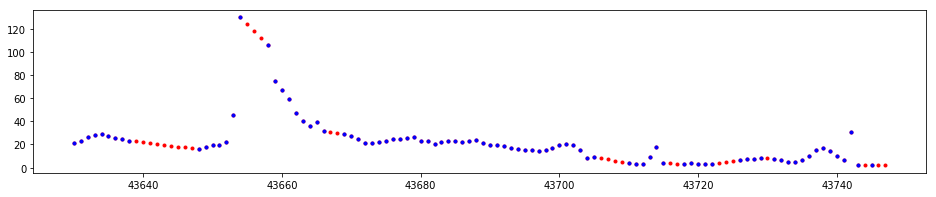

In [30]:
fig,ax=plt.subplots(1,1,figsize=(16,3))
ax.plot(dfdaily['DayNum'],dfdaily['Turb_NTU'],'r.')
ax.plot(oldDD,oldT,'b.')

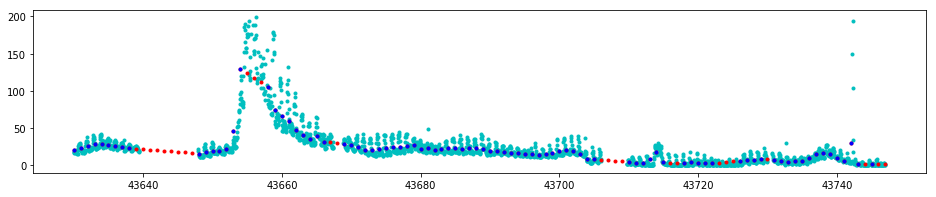

In [31]:
fig,ax=plt.subplots(1,1,figsize=(16,3))
ax.plot(df['DecDay'],df['Turb_NTU'],'c.')
ax.plot(dfdaily['DayNum'],dfdaily['Turb_NTU'],'r.')
ax.plot(oldDD,oldT,'b.')

In [32]:
iday=(startdate-dt.date(1900,1,1)).days
iTurb=dfdaily[dfdaily.DayNum==iday]['Turb_NTU'].values[0]
iTurb

21.006666666666664

## Interpolation/averaging look OK; now create files: 

create daily Fraser turbidity files:

In [33]:
f=nc.Dataset('/results/forcing/rivers/RLonFraCElse_y2016m01d23.nc') # example for dims
fnamebase='/ocean/eolson/MEOPAR/NEMO-forcing/rivers/riverTurbDaily201906_'
for idate in daterange(startdate,enddate):
    iday=(idate-dt.date(1900,1,1)).days
    lower=iday
    upper=iday+1
    iTurb=dfdaily[dfdaily.DayNum==iday]['Turb_NTU'].values[0]

    fname=fnamebase+idate.strftime('y%Ym%md%d')+'.nc'

    new=nc.Dataset(fname,'w')
    #Copy dimensions
    for dname, the_dim in f.dimensions.items():
        #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
        new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
    # create dimension variables:
    new_x=new.createVariable('nav_lat',np.float32,('y','x'),zlib=True)
    new_x[:]=f.variables['nav_lat'][:,:]

    new_y=new.createVariable('nav_lon',np.float32,('y','x'),zlib=True)
    new_y[:]=f.variables['nav_lon'][:,:]

    new_tc=new.createVariable('time_counter',np.float32,('time_counter'),zlib=True)
    new_tc[:]=f.variables['time_counter'][:]
    
    new_run=new.createVariable('turb',float,('time_counter', 'y', 'x'),zlib=True)
    new_run[:,:,:]=-999.99 # most cells are masked with negative numbers
    new_run[:,400:448, 338:380]=iTurb # set turbidity to daily average
    new_run[:,440:503,363:398]=iTurb # extend Turbidity all the way up river

    new.close()

In [41]:
ftest=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/rivers/riverTurbDaily201906_y2019m09d02.nc')

In [42]:
ftest

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(398), y(898), time_counter(1)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 time_counter(time_counter), float64 turb(time_counter,y,x)
    groups: 

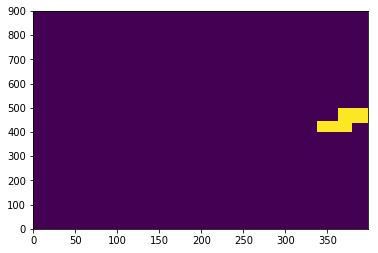

In [43]:
plt.pcolormesh(ftest.variables['turb'][0,:,:])

In [51]:
ftest.variables['turb'][0,395:420,364:368]

masked_array(
  data=[[-999.99  , -999.99  , -999.99  , -999.99  ],
        [-999.99  , -999.99  , -999.99  , -999.99  ],
        [-999.99  , -999.99  , -999.99  , -999.99  ],
        [-999.99  , -999.99  , -999.99  , -999.99  ],
        [-999.99  , -999.99  , -999.99  , -999.99  ],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.1205,    6.1205,    6.1205,    6.1205],
        [   6.

In [38]:
ftest.close()